In [15]:
import os
from scipy.io import wavfile
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
from torchaudio.compliance import kaldi
import utils

sample rate: 16000, wave size: (243440,)


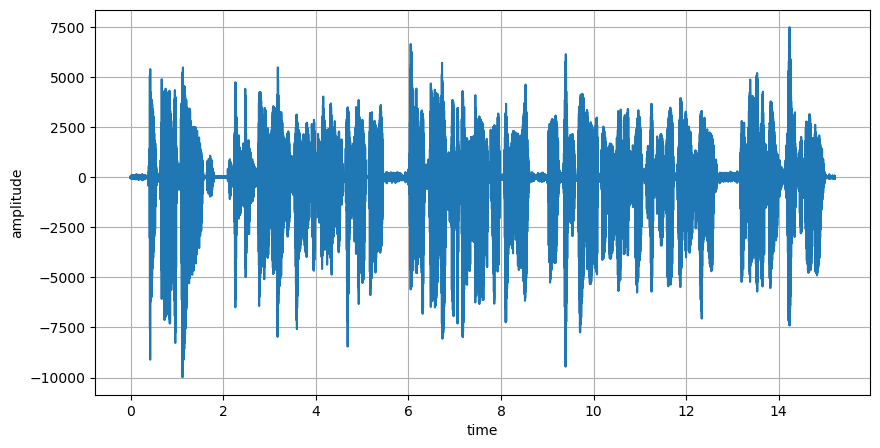

In [25]:
# sample wave
sample_rate, wave = wavfile.read('wavs/dev/107-22885-0023.wav')
time = np.arange(0, wave.shape[0]) * (1.0 / sample_rate)
print('sample rate: {}, wave size: {}'.format(sample_rate, wave.shape))
plt.figure(figsize=(10, 5))
plt.plot(time, wave)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.grid()
plt.savefig('./figure/linear_wave_origin.png')
plt.show()

feature size: (1522, 4)


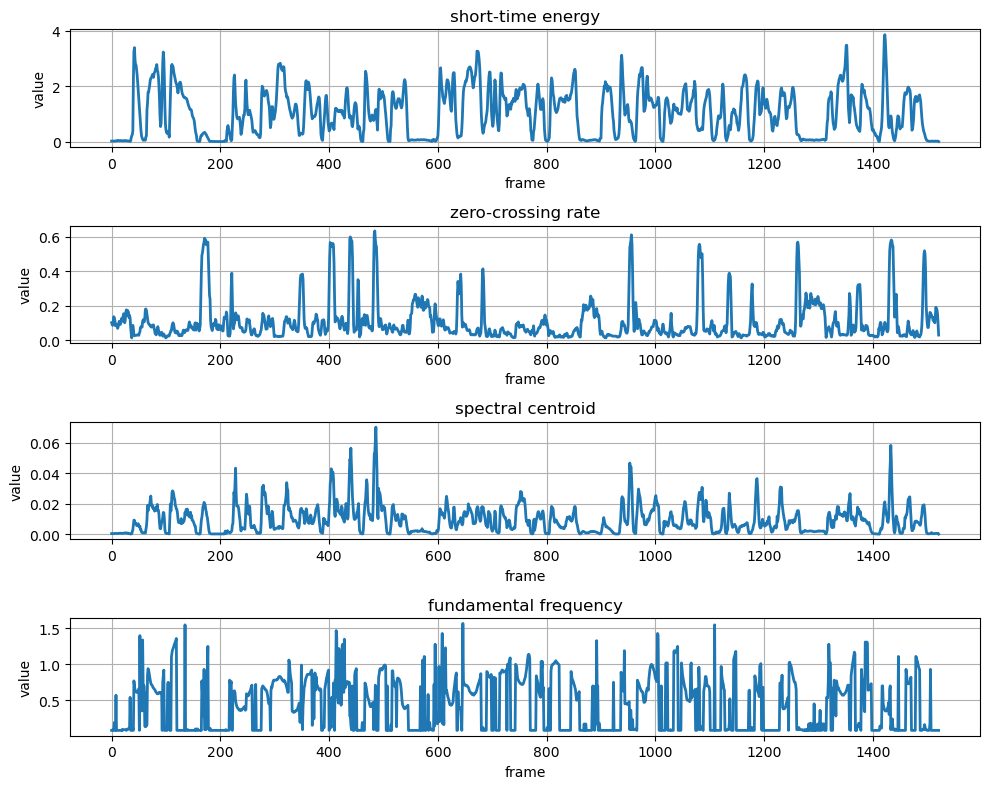

In [26]:
# basic feature
feature = utils.wave_feature(wave, sample_rate)
name = ['short-time energy', 'zero-crossing rate', 'spectral centroid', 'fundamental frequency']
print('feature size: {}'.format(feature.shape))
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(4, 1, i + 1)
    plt.plot(feature[:, i], linewidth=2)
    plt.xlabel('frame')
    plt.ylabel('value')
    plt.title(name[i])
    plt.grid()
plt.tight_layout()
plt.savefig('./figure/linear_wave_feature.png')
plt.show()

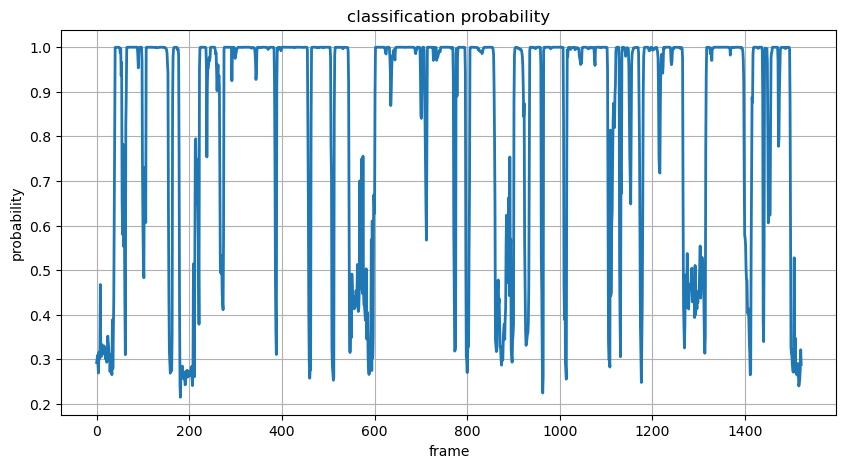

In [ ]:
# probability by linear classifier
with open('./model/linear.pkl', 'rb') as file:
    classifier = pickle.load(file)
sample_rate, wave = wavfile.read('./wavs/dev/107-22885-0023.wav')
feature = utils.wave_feature(wave, sample_rate)
probability = classifier.predict_proba(feature)[:, 1]
plt.figure(figsize=(10, 5))
plt.plot(probability, linewidth=2)
plt.xlabel('frame')
plt.ylabel('probability')
plt.title('classification probability')
plt.grid()
plt.savefig('./figure/linear_probability_origin.png')
plt.show()


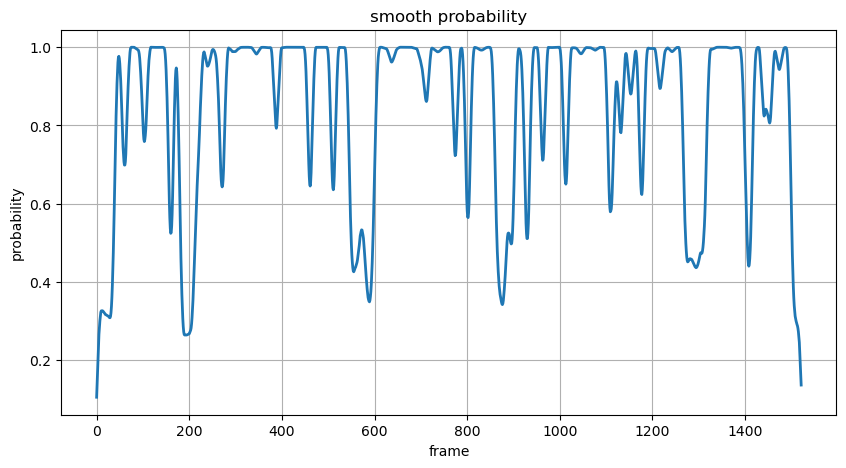

In [27]:
# smooth probability by linear classifier
probability = utils.mean_filtering(probability)
plt.figure(figsize=(10, 5))
plt.plot(probability, linewidth=2)
plt.xlabel('frame')
plt.ylabel('probability')
plt.title('smooth probability')
plt.grid()
plt.savefig('./figure/linear_probability_smooth.png')
plt.show()

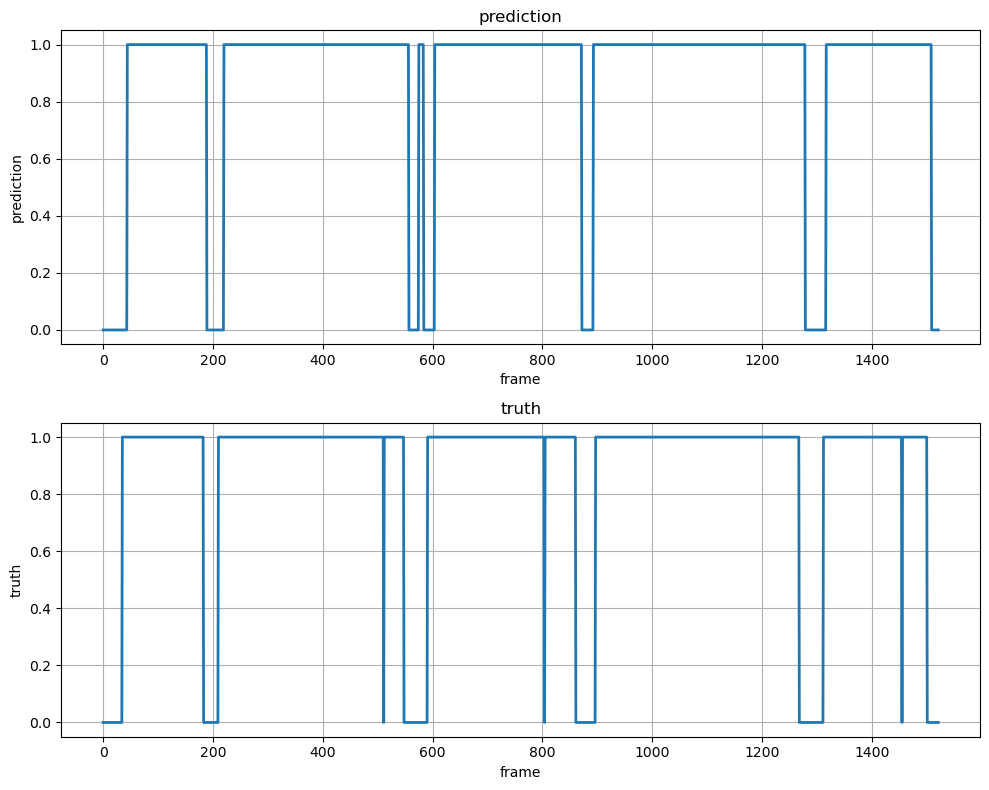

In [28]:
# prediction by linear classifier
prediction = utils.generate_prediction(probability)
truth = np.array(utils.read_label_from_file('./data/dev_label.txt')['107-22885-0023'])
truth = np.pad(truth, (0, prediction.shape[0] - len(truth)), 'constant', constant_values=(0, 0))
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(prediction, linewidth=2)
plt.xlabel('frame')
plt.ylabel('prediction')
plt.title('prediction')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(truth, linewidth=2)
plt.xlabel('frame')
plt.ylabel('truth')
plt.title('truth')
plt.grid()
plt.tight_layout()
plt.savefig('./figure/linear_prediction_result.png')
plt.show()

100%|██████████| 500/500 [01:32<00:00,  5.40it/s]


accuracy: 0.9171, area under curve: 0.9658, equal error rate: 0.0872


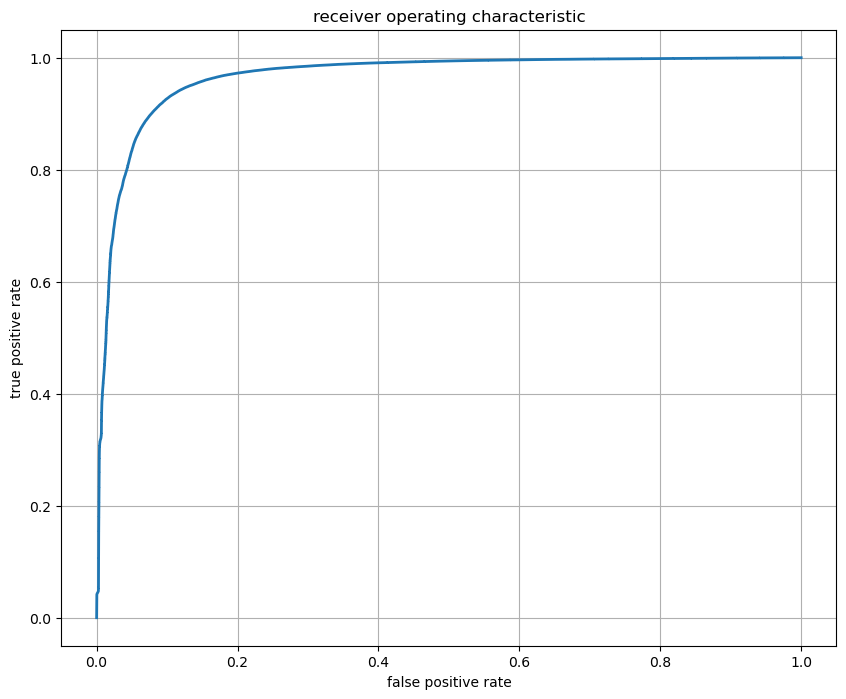

In [ ]:
# receiver operating characteristic by linear classifier
data = utils.read_label_from_file('./data/dev_label.txt')
prob_list, pred_list, real_list = [], [], []
for name, value in tqdm(data.items()):
    path = os.path.join('./wavs/dev', name + '.wav')
    sample_rate, wave = wavfile.read(path)
    feature = utils.wave_feature(wave, sample_rate)
    prob = utils.mean_filtering(classifier.predict_proba(feature)[:, 1])
    pred = utils.generate_prediction(prob)
    real = np.pad(np.array(value), (0, feature.shape[0] - len(value)), 'constant', constant_values=(0, 0))
    prob_list.append(prob)
    pred_list.append(pred)
    real_list.append(real)
prob_list = np.concatenate(prob_list, axis=0)
pred_list = np.concatenate(pred_list, axis=0)
real_list = np.concatenate(real_list, axis=0)
acc = utils.compute_acc(pred_list, real_list)
auc, err, fpr, tpr = utils.get_metrics(prob_list, real_list)
print('accuracy: {:.4f}, area under curve: {:.4f}, equal error rate: {:.4f}'.format(acc, auc, err))
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating characteristic')
plt.grid()
plt.savefig('./figure/linear_verify_curve.png')
plt.show()

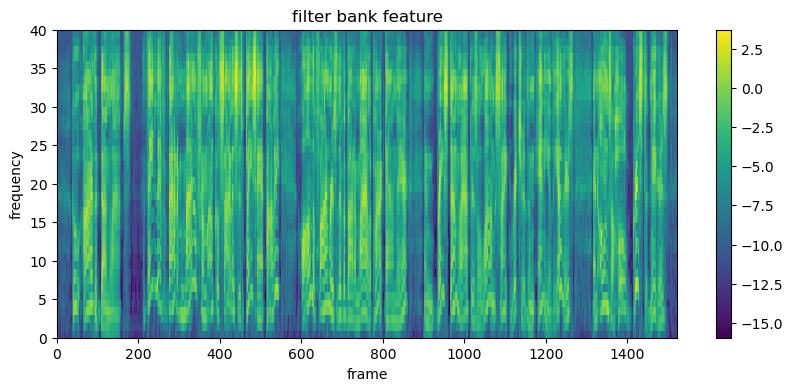

In [27]:
# feature on frequency domain
wave, sample_rate = torchaudio.load('./wavs/dev/107-22885-0023.wav')
feature = kaldi.fbank(wave, sample_frequency=sample_rate, num_mel_bins=40, snip_edges=False).numpy()
plt.figure(figsize=(10, 4))
heat = plt.pcolor(feature.T)
plt.colorbar(heat)
plt.xlabel('frame')
plt.ylabel('frequency')
plt.title('filter bank feature')
plt.savefig('./figure/statistic_wave_feature.png')
plt.show()

In [28]:
# structure of neural network
class VAD_Dataset(Dataset):
    def __init__(self, mode='test'):
        save_path = os.path.join('./data', mode + '_data.pt')
        if os.path.exists(save_path):
            self.feature, self.label = torch.load(save_path)
        else:
            data_path = os.path.join('./data', mode + '_label.txt')
            wave_path = os.path.join('./wavs', mode)
            data = utils.read_label_from_file(data_path)
            feature_list, label_list = [], []
            for name, value in tqdm(data.items()):
                path = os.path.join(wave_path, name + '.wav')
                wave, rate = torchaudio.load(path)
                feature = kaldi.fbank(wave, sample_frequency=rate, num_mel_bins=40, snip_edges=False)
                label = F.pad(torch.Tensor(value), (0, feature.shape[0] - len(value)), 'constant', 0)
                feature_list.append(feature)
                label_list.append(label)
            self.feature = torch.cat(feature_list, dim=0)
            self.label = torch.cat(label_list, dim=0)
            torch.save((self.feature, self.label), save_path)

    def __getitem__(self, index):
        return self.feature[index], self.label[index]

    def __len__(self):
        return self.feature.shape[0]


class VAD_Model(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=256, output_dim=1):
        super(VAD_Model, self).__init__()
        linear_layer = [
            nn.Linear(input_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, output_dim)
        ]
        norm_layer = [
            nn.BatchNorm1d(hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.BatchNorm1d(hidden_dim),
        ]
        for layer in linear_layer:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
        self.network = nn.Sequential(
            linear_layer[0],
            norm_layer[0],
            nn.ReLU(True),
            linear_layer[1],
            norm_layer[1],
            nn.ReLU(True),
            linear_layer[2],
            norm_layer[2],
            nn.ReLU(True),
            linear_layer[3],
            nn.Sigmoid()
        )

    def forward(self, inputs):
        outputs = self.network(inputs)
        return outputs

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load('./model/statistic.pth').to(device)
print(model)

VAD_Model(
  (network): Sequential(
    (0): Linear(in_features=40, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


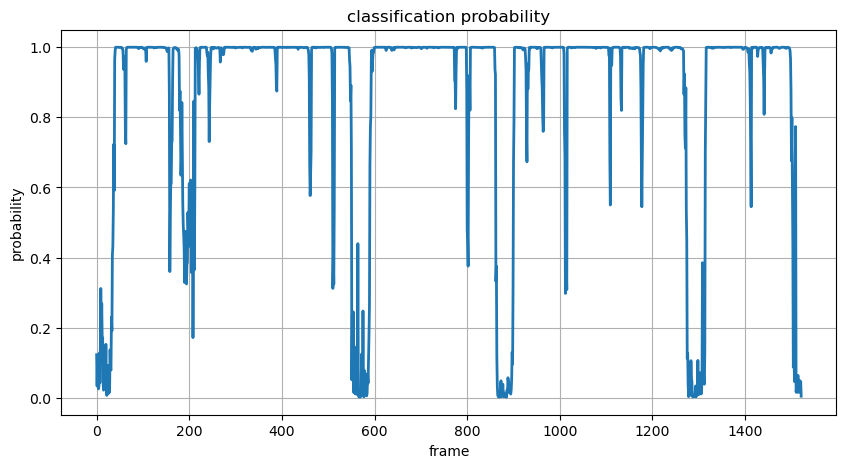

In [29]:
# probability by statistic classifier
wave, sample_rate = torchaudio.load('./wavs/dev/107-22885-0023.wav')
feature = kaldi.fbank(wave, sample_frequency=sample_rate, num_mel_bins=40, snip_edges=False).to(device)
with torch.no_grad():
    probability = model(feature).squeeze(-1).cpu().numpy()
plt.figure(figsize=(10, 5))
plt.plot(probability, linewidth=2)
plt.xlabel('frame')
plt.ylabel('probability')
plt.title('classification probability')
plt.grid()
plt.savefig('./figure/statistic_probability_origin.png')
plt.show()

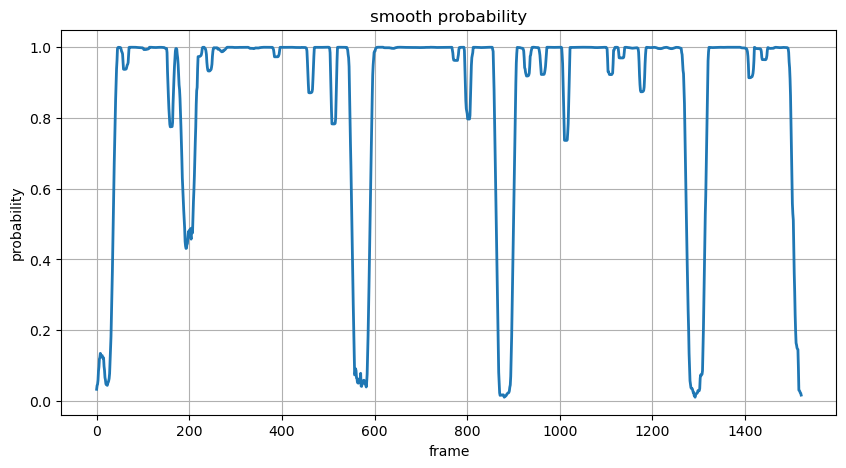

In [30]:
# smoothing probability by statistic classifier
probability = utils.mean_filtering(probability, width=12)
plt.figure(figsize=(10, 5))
plt.plot(probability, linewidth=2)
plt.xlabel('frame')
plt.ylabel('probability')
plt.title('smooth probability')
plt.grid()
plt.savefig('./figure/statistic_probability_smooth.png')
plt.show()

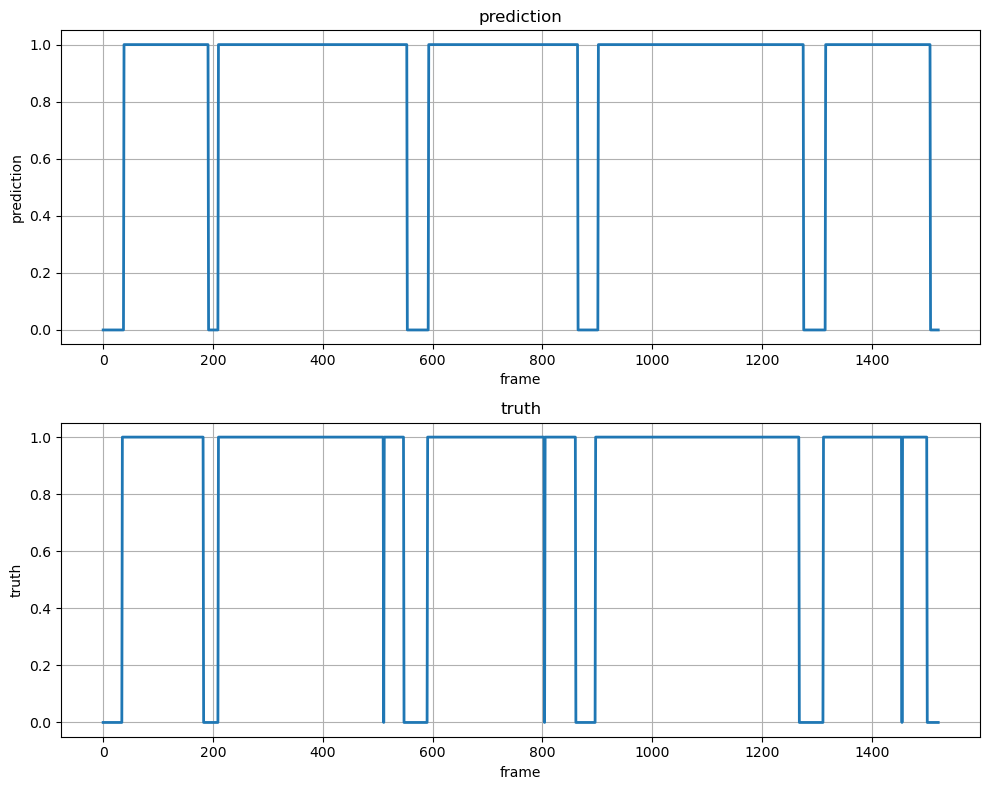

In [32]:
# prediction by statistic classifier
prediction = utils.generate_prediction(probability, holder=3)
truth = np.array(utils.read_label_from_file('./data/dev_label.txt')['107-22885-0023'])
truth = np.pad(truth, (0, prediction.shape[0] - len(truth)), 'constant', constant_values=(0, 0))
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(prediction, linewidth=2)
plt.xlabel('frame')
plt.ylabel('prediction')
plt.title('prediction')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(truth, linewidth=2)
plt.xlabel('frame')
plt.ylabel('truth')
plt.title('truth')
plt.grid()
plt.tight_layout()
plt.savefig('./figure/statistic_prediction_result.png')
plt.show()

100%|██████████| 688/688 [00:19<00:00, 36.19it/s]


accuracy: 0.9520, area under curve: 0.9901, equal error rate: 0.0466


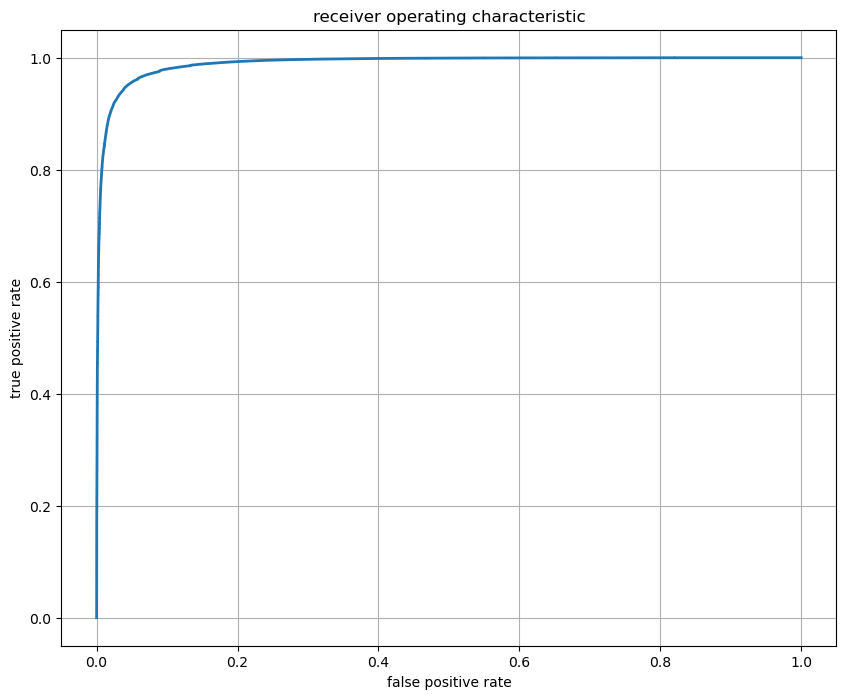

In [33]:
# receiver operating characteristic by statistic classifier
dataset = VAD_Dataset('dev')
loader = DataLoader(dataset, batch_size=1024, drop_last=False)
prob_list, pred_list, real_list = [], [], []
with torch.no_grad():
    for feature, label in tqdm(loader):
        feature, label = feature.to(device), label.to(device)
        result = model(feature).squeeze(-1)
        prob = utils.mean_filtering(result.cpu().numpy(), width=12)
        pred = utils.generate_prediction(prob, holder=3)
        real = label.cpu().numpy()
        prob_list.append(prob)
        pred_list.append(pred)
        real_list.append(real)
prob_list = np.concatenate(prob_list, axis=0)
pred_list = np.concatenate(pred_list, axis=0)
real_list = np.concatenate(real_list, axis=0)
acc = utils.compute_acc(pred_list, real_list)
auc, err, fpr, tpr = utils.get_metrics(prob_list, real_list)
print('accuracy: {:.4f}, area under curve: {:.4f}, equal error rate: {:.4f}'.format(acc, auc, err))
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating characteristic')
plt.grid()
plt.savefig('./figure/statistic_verify_curve.png')
plt.show()